# Constructing dataset for inferring advice-seeking intentions

In [2]:
from convokit import Corpus, Utterance, Speaker, download
from convokit.text_processing import TextProcessor, TextCleaner, TextParser
from cleantext import clean
from collections import Counter

The corpus we will use is from the subreddit r/Advice, which is a place where ''a place where anyone can seek advice on any subject":

In [3]:
advice_corpus = Corpus(download('subreddit-Advice', \
                         data_dir='/belafonte_sauna/liye_translations/convokit_asq/'))

Dataset already exists at /belafonte_sauna/liye_translations/convokit_asq/subreddit-Advice


In [4]:
advice_corpus.print_summary_stats()

Number of Speakers: 297673
Number of Utterances: 2373849
Number of Conversations: 405056


## 1. Clean and parse posts

We start off by doing a little bit of preprocessing:

* We will use a TextCleaner to do some basic cleaning such as fixing unicode errors, striping line breaks and convering text to lower case. We slightly deviate from the ConvoKit's default by allowing numbers and currency symbols, since they might provide relevant contexts for advice-seeking. 

* We will then tokenize the utterances using a TextParser, with the mode *tokenize*, since we will not be needing dependence parses (which can take a while to compute). 

We slightly deviate from the ConvoKit's default TextCleaner behavior by allowing numbers and currency symbols, since they might provide relevant contexts for advice-seeking. 

In [5]:
# input filter we will use throughout 
post_filter = lambda utt:utt.reply_to is None

# path for where we'd like to save the output to
OUTPUT_PATH = "/belafonte_sauna/liye_translations/convokit_asq/filtered_pairs_oct6.json"

In [6]:
clean_fn = lambda s: clean(s, no_numbers=False, no_digits=False, \
                           no_currency_symbols=False, no_punct=False)

cleaner = TextCleaner(text_cleaner=clean_fn, input_filter=post_filter, verbosity=50000)

advice_corpus = cleaner.transform(advice_corpus)

50000/2373849 utterances processed
100000/2373849 utterances processed
150000/2373849 utterances processed
200000/2373849 utterances processed
250000/2373849 utterances processed
300000/2373849 utterances processed
350000/2373849 utterances processed
400000/2373849 utterances processed
450000/2373849 utterances processed
500000/2373849 utterances processed
550000/2373849 utterances processed
600000/2373849 utterances processed
650000/2373849 utterances processed
700000/2373849 utterances processed
750000/2373849 utterances processed
800000/2373849 utterances processed
850000/2373849 utterances processed
900000/2373849 utterances processed
950000/2373849 utterances processed
1000000/2373849 utterances processed
1050000/2373849 utterances processed
1100000/2373849 utterances processed
1150000/2373849 utterances processed
1200000/2373849 utterances processed
1250000/2373849 utterances processed
1300000/2373849 utterances processed
1350000/2373849 utterances processed
1400000/2373849 utter

In [7]:
parser = TextParser(mode='tokenize', input_filter=post_filter, verbosity=50000)
advice_corpus = parser.transform(advice_corpus)

50000/2373849 utterances processed
100000/2373849 utterances processed
150000/2373849 utterances processed
200000/2373849 utterances processed
250000/2373849 utterances processed
300000/2373849 utterances processed
350000/2373849 utterances processed
400000/2373849 utterances processed
450000/2373849 utterances processed
500000/2373849 utterances processed
550000/2373849 utterances processed
600000/2373849 utterances processed
650000/2373849 utterances processed
700000/2373849 utterances processed
750000/2373849 utterances processed
800000/2373849 utterances processed
850000/2373849 utterances processed
900000/2373849 utterances processed
950000/2373849 utterances processed
1000000/2373849 utterances processed
1050000/2373849 utterances processed
1100000/2373849 utterances processed
1150000/2373849 utterances processed
1200000/2373849 utterances processed
1250000/2373849 utterances processed
1300000/2373849 utterances processed
1350000/2373849 utterances processed
1400000/2373849 utter

## 2. Seperating questions from narratives 

The first step to construct the (narrative, questions) pairs is by seperating questions from the original advice-seeking post. We consider the question-stripped text as the __narrative__ that provides enough contexts and we consider the identified questions are possible candidates for indicating the OP's advice-seeking intentions. 

We will use a custom `QuestionCloze` transformer to produce, for each utterance (i.e., an advice-seeking post), the question-masked narrative (saved under `masked_text`) and questions found in the utterance (saved under `questions`). 

In [8]:
# seperating questions and narratives
from questionCloze import QuestionCloze

In [9]:
qcloze = QuestionCloze(input_filter=post_filter, verbosity=50000)
advice_corpus = qcloze.transform(advice_corpus)

50000/2373849 utterances processed
100000/2373849 utterances processed
150000/2373849 utterances processed
200000/2373849 utterances processed
250000/2373849 utterances processed
300000/2373849 utterances processed
350000/2373849 utterances processed
400000/2373849 utterances processed
450000/2373849 utterances processed
500000/2373849 utterances processed
550000/2373849 utterances processed
600000/2373849 utterances processed
650000/2373849 utterances processed
700000/2373849 utterances processed
750000/2373849 utterances processed
800000/2373849 utterances processed
850000/2373849 utterances processed
900000/2373849 utterances processed
950000/2373849 utterances processed
1000000/2373849 utterances processed
1050000/2373849 utterances processed
1100000/2373849 utterances processed
1150000/2373849 utterances processed
1200000/2373849 utterances processed
1250000/2373849 utterances processed
1300000/2373849 utterances processed
1350000/2373849 utterances processed
1400000/2373849 utter

Now, utterances that are posts should be annotated with *masked_text* and *questions*, see below for an example:

In [10]:
utt = advice_corpus.random_utterance()
while utt.reply_to:
    utt = advice_corpus.random_utterance()

print(utt.meta['masked_text'])
print('\t', utt.meta['questions'])

hi , i am a 16 yr old guy , nearly 17and i think there s something mentally wrong with me . i want to discuss it here , but i m not sure if i could get banned discussing the problem . i just came here cause i ca n't tell anyone irl , i would be looked down upon , and get zero sympathy , which i do n't expect to get any here either , which i totally understand .
	 []


## 3. Selecting appropriate question

Next, among all the possible question candidates, we use a `QuestionSelector` to find one "most appropriate" question for each narrative. 

Our selection criteria is to consider the specificity of the question---as approximated by max idf of the words---and the position it appears (earlier is better). This is not necessarily the best approach, but seems to produce good enough results. 

In [11]:
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
vectorizer = TfidfVectorizer(min_df=20)

# We use the original text collection to compute the idf
texts = [utt.text for utt in advice_corpus.iter_utterances() if utt.reply_to is None]
vectorizer.fit(texts)

TfidfVectorizer(min_df=20)

In [13]:
word2idf = defaultdict(int)
for k, v in zip(vectorizer.get_feature_names(), vectorizer.idf_):
    word2idf[k] = v

We now select questions, keeping both the selected question (saved under `sel_question`), and its position in the post (saved under `sel_question_pos`), in terms of sentence index

In [15]:
from questionSelector import QuestionSelector

In [16]:
qselector = QuestionSelector(word2idf=word2idf, input_filter=post_filter, verbosity=50000)

In [17]:
advice_corpus = qselector.transform(advice_corpus)

50000/2373849 utterances processed
100000/2373849 utterances processed
150000/2373849 utterances processed
200000/2373849 utterances processed
250000/2373849 utterances processed
300000/2373849 utterances processed
350000/2373849 utterances processed
400000/2373849 utterances processed
450000/2373849 utterances processed
500000/2373849 utterances processed
550000/2373849 utterances processed
600000/2373849 utterances processed
650000/2373849 utterances processed
700000/2373849 utterances processed
750000/2373849 utterances processed
800000/2373849 utterances processed
850000/2373849 utterances processed
900000/2373849 utterances processed
950000/2373849 utterances processed
1000000/2373849 utterances processed
1050000/2373849 utterances processed
1100000/2373849 utterances processed
1150000/2373849 utterances processed
1200000/2373849 utterances processed
1250000/2373849 utterances processed
1300000/2373849 utterances processed
1350000/2373849 utterances processed
1400000/2373849 utter

We will also compute some helpful stats, to help further filter valid (narrative, question) pairs.

In [18]:
scnt = TextProcessor(proc_fn=lambda parses: len(parses), \
                     output_field='num_sents', input_field='parsed', \
                     input_filter=post_filter)

wcnt = TextProcessor(proc_fn=lambda text: len(text.split()), \
                     output_field='num_words', input_field='masked_text', \
                     input_filter=lambda utt:utt.reply_to is None)

advice_corpus = wcnt.transform(advice_corpus)
advice_corpus = scnt.transform(advice_corpus)

## 4. Exporting valid (narrative, question) pairs

Now we will get all information we need into a dataframe for some minor filtering.

In [19]:
narrative_df = advice_corpus.get_utterances_dataframe(selector=post_filter)
narrative_df = narrative_df[['text', 'meta.masked_text', 'meta.questions', 'meta.sel_question', 'meta.sel_question_pos', \
                             'meta.num_words', 'meta.num_sents']]

We are now ready to apply various filters and see their effects on the data size:

In [42]:
# filter narratives for which no question is retrieved 
base_cnt = len(narrative_df)
filtered_cnts = []

# 1. keep only instances in which explicit questions are identified, i.e., 'questions' isn't empty
filtered_df = narrative_df[narrative_df['meta.questions'].map(bool)]
filtered_cnts.append(len(filtered_df))

# 2. keep only instances in which question is selected successfully 
filtered_df = filtered_df[(filtered_df['meta.sel_question'].notnull())]
filtered_cnts.append(len(filtered_df))

# 3. keep only texts where the masked narrative is within a given length range 
filtered_df = filtered_df[(filtered_df['meta.num_words']>=100) & (filtered_df['meta.num_words']<=400)]
filtered_cnts.append(len(filtered_df))

# 4. filtering out instances where tl;dr is present
filtered_df = filtered_df[(~filtered_df['meta.masked_text'].str.contains('tl;dr')) & \
                          (~filtered_df['meta.masked_text'].str.contains('tldr'))]
filtered_cnts.append(len(filtered_df))

# 5. filtering out most common questions (at sentence level)
common_qns = {qn for qn, _ in Counter(filtered_df['meta.sel_question']).most_common(20)}
filtered_df = filtered_df[~filtered_df['meta.sel_question'].isin(common_qns)]
filtered_cnts.append(len(filtered_df))

for i, cnt in enumerate(filtered_cnts):
    print("step {}: {}/{} ({:.2f}%)".format(i+1, base_cnt, cnt, 100*cnt/base_cnt))

step 1: 405056/189583 (46.80%)
step 2: 405056/66537 (16.43%)
step 3: 405056/33745 (8.33%)
step 4: 405056/31872 (7.87%)
step 5: 405056/31562 (7.79%)


Finally, since our filters are based on some heuristics, some very generic questions can still escape, we will inspect from some frequent questions to ignore some very generic ones:

Below are some example (narrative, question) pairs:

In [44]:
for item in filtered_df[0:10].itertuples():
    print("===Narrative===")
    print(item[2])
    print('------------')
    print("Question:", [qn for qn, _ in item[3]])
    print("Selected question:", item[4])
    print()

===Narrative===
so , a month ago , i got hired as a cook at golden corral . it was in * really * poor shape and the regular paycheck there really helped me out . i was able to get some food and keep my bills relatively under control . i hate the job at golden corral . it is miserable , unsatisfying work that leaves me coming home at night smelling terrible with my covered with burns ( i get to work the fryers ! : d ) . the only benefit from working at the place is that i 've met some cool people . my situation is under control , and i have opportunity to get a better job elsewhere . more satisfying , better pay and wo n't leave me hating everything . i want to quit , but i also feel bad doing so so soon after i started working . i also feel like i 'm gon na hurt the people i 've met there that have helped me out to figure out everything that i need to do . i do n't know exactly what i 'm looking for with this post .
------------
Question: ['how can i leave this job without feeling guil

One may be curious where our selected questions come from. Perhaps not surprising, most of them are found nearing the end. The final drop is most likely due to our deliberate (but somewhat arbitrary) decision to give priority over earlier questions.

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([ 328.,  247.,  405.,  702.,  994., 2633., 3888., 6494., 9176.,
        7005.]),
 array([0.0, 0.0975, 0.195, 0.2925, 0.39, 0.48750000000000004, 0.585,
        0.6825, 0.78, 0.8775000000000001, 0.975], dtype=object),
 <a list of 10 Patch objects>)

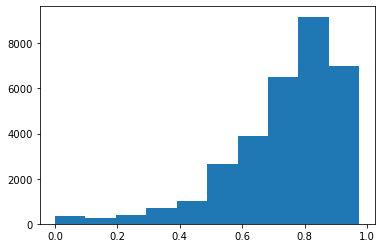

In [27]:
plt.hist(filtered_df['meta.sel_question_pos'] / filtered_df['meta.num_sents'])

In [45]:
# save the output to 
filtered_df.to_json(OUTPUT_PATH)